# Objective: Understand how to overlay pyplot hist objects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# How does this work? the n, bins, patches part?
https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width

In [2]:
#Peak VCD per D42 bioreactor for experiment and control 
exp = [42.62, 54.55, 62.75, 62.4, 53.29, 60.7, 21.37, 35.56, 18.51, 36.54, 43.38, 15.91, 25.12, 22.2, 34.68,
       47.89, 41.09, 43.8, 27.3, 35.38, 72.46, 33.51, 22.96, 48.92, 64.26, 18.83, 8.59, 24.63, 28.36, 29.63, 
       28.47, 43.18, 30.89, 24.19, 21.52, 31.11, 40.76, 31.94, 34.82, 7.45, 19.9]
control = [29.97, 30.32, 48.28, 30.95, 27.34, 31.37, 35.77, 29.25]

#### Converting lists of data to DF attempt 1

Problem: Cannot convert lists of different lengths into a dataframe 

In [3]:
#long solution: convert to dict of series manually then to dataframe 
exp_series = pd.Series(exp)
control_series = pd.Series(control)

series_dict = {"a":exp_series,
              "b":control_series}

#Dataframe came make dataframes from Series dtypes that are not the same length but not from lists 
df_data = pd.DataFrame(series_dict)

In [4]:
#more concise way, use dict comprehension to convert dict of lists to dict of series then to dataframe 

data_dict = {"exp": exp,
            "control": control}

series_dict_1 = {k: pd.Series(v) for k,v in data_dict.items()}
df_data_1 = pd.DataFrame(series_dict_1)


#### Converting lists of data to DF attempt 2

Problem: joined dataframe may work for historgrams in this case, but want to be able to have 1 data column and descriptive column, then group and plot

In [5]:
# long solution: manually create extra column with type of data then concat, reset index and drop old index 

In [7]:
#manual series to dataframe and manual add of type column
df_test_exp = pd.DataFrame(exp_series, columns = ["vcd"])
df_test_exp["type"] = "exp"

df_test_control = pd.DataFrame(control_series, columns = ["vcd"])
df_test_control["type"] = "control"

df_merged = pd.concat([df_test_control, df_test_exp]) #glue together on axis = 0

df_merged.reset_index(inplace = True, drop = True) #reset index and drop old index and done!

### OK now need to plot the histograms

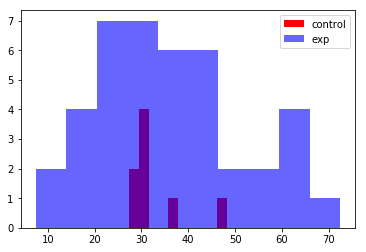

In [43]:
plt.hist(df_merged[df_merged["type"] == "control"]["vcd"], label ="control", color = "red")
plt.hist(df_merged[df_merged["type"] == "exp"]["vcd"], label = "exp", alpha = 0.6, color = "b")
plt.legend()

type
control    AxesSubplot(0.125,0.125;0.775x0.755)
exp        AxesSubplot(0.125,0.125;0.775x0.755)
Name: vcd, dtype: object

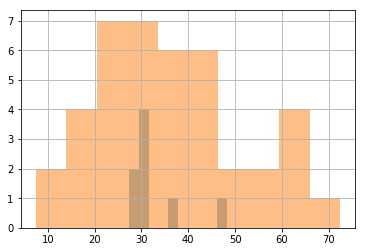

In [54]:
df_merged.groupby("type")["vcd"].hist(alpha = 0.5)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022C2FDC5358>]],
      dtype=object)

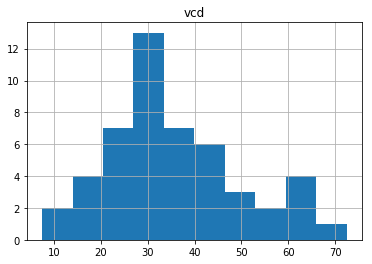

In [52]:
df_merged.hist()

### To learn 

How to generally interacts with the pandas plots 
- how to change color on the pandas plots 
- how to change titles on the pandas plots 

How to set plot styles to be seaborn like but without background or grid 

How to create grouped overlayed histograms for every feature


links:
https://stackoverflow.com/questions/23617129/matplotlib-how-to-make-two-histograms-have-the-same-bin-width
^ whats up with n bins batches?
https://stackoverflow.com/questions/35878064/plot-two-histograms-on-the-same-graph-and-have-their-columns-sum-to-100
^generic histogram plot

In [55]:
pwd

'C:\\Users\\agilman\\Desktop\\Repositories\\Gilman_earning\\Python_tutorials'

In [57]:
pd.read_csv("D42-CHR-0060 DOE JMP 100418 Day14Subset.csv")

,Bioreactor ID,Cond,pH Deadband,Temp Shift Day,DO Sparge Rate,Temp Shift,pH Set-point,Agitation,Peak VCD (10E6 c/mL),D14 Viability (%),...,rCE Other peaks (%),SEC HMW (%),SEC Main (%),SEC LMW (%),M5 (%),N-Glycan NonFuco (%),N-Glycan Fuco (%),CEX-Acidic (%),CEX-Main (%),CEX-Basic (%)
0,R4558,control,0.2,4,30,32,7.0,200,29.97,78.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R4559,control,0.2,4,30,32,7.0,200,30.32,61.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R4565,Exp,0.1,4,60,32,6.8,200,42.62,73.90,...,0.800000,5.0,94.8,0.2,2.40,1.9,87.60,11.6000,72.500,15.9000
3,R4566,Exp,0.2,3,20,34,6.8,100,54.55,43.26,...,1.200000,3.2,94.5,2.3,1.50,1.6,92.70,26.6000,65.700,7.7000
4,R4567,Exp,0.2,5,40,32,7.0,150,62.75,64.06,...,3.500000,2.2,97.5,0.2,2.50,2.9,87.20,17.1000,64.400,16.5000
5,R4568,Exp,0.3,3,60,34,7.2,100,62.40,41.70,...,4.999711,2.4,95.4,2.2,1.15,2.0,92.83,24.6133,64.243,11.1436
6,R4569,Exp,0.2,4,40,32,7.0,150,53.29,70.74,...,4.300000,2.5,97.4,0.1,1.90,2.2,88.30,14.1000,70.000,15.9000
7,R4570,Exp,0.1,5,60,34,7.2,100,60.70,52.10,...,8.100000,2.6,95.2,2.2,3.30,2.2,84.20,22.3000,58.000,19.8000
8,R4571,Exp,0.1,3,60,30,7.2,100,21.37,90.18,...,1.000000,5.9,93.9,0.2,1.50,1.6,92.70,11.5000,68.300,20.2000
9,R4572,Exp,0.1,5,60,30,6.8,100,35.56,89.98,...,4.000000,5.7,92.2,2.1,3.90,2.5,86.30,11.7000,66.300,22.0000
